# **RAG Survey 2024**

A survey on RAG development using data sourced from arxiv. 
 

## 1. Search for papers and abstracts from arxiv


In [16]:
import requests
import xml.etree.ElementTree as ET

# Define the ArXiv API endpoint and query parameters
API_URL = "http://export.arxiv.org/api/query"
query_params = {
    "search_query": "all:\"retrieval augmented generation\"",
    "start": 0,
    "max_results": 5000
}

# Fetch the response from the API
response = requests.get(API_URL, params=query_params)
if response.status_code == 200:
    # Save the response XML to a file
    with open("data/arxiv_response.xml", "w", encoding="utf-8") as file:
        file.write(response.text)
    print("Response saved to arxiv_response.xml")
else:
    print(f"Failed to fetch data. Status code: {response.status_code}")
    exit()

# Parse the XML response
root = ET.fromstring(response.text)

# Define the namespace for parsing ArXiv's XML
namespace = {
    "atom": "http://www.w3.org/2005/Atom",
    "arxiv": "http://arxiv.org/schemas/atom"
}

# Extract data from each entry
results = []
for entry in root.findall("atom:entry", namespace):
    published_date = entry.find("atom:published", namespace).text
    href_link = entry.find("atom:link[@rel='alternate']", namespace).attrib['href']
    title = entry.find("atom:title", namespace).text.strip()
    summary = entry.find("atom:summary", namespace).text.strip()
    first_author = entry.find("atom:author/atom:name", namespace).text.strip()

    results.append([published_date, href_link, title, summary, first_author])

# Pring number of results
print(f"Number of results: {len(results)}")

# Display the results
# for result in results:
#    print(result)

# Optional: Save results to a file
import csv
with open("data/arxiv_results.csv", "w", newline="", encoding="utf-8") as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(["Published Date", "Link", "Title", "Summary", "First Author"])
    csvwriter.writerows(results)

print("Results saved to arxiv_results.csv")
 

Response saved to arxiv_response.xml
Number of results: 1314
Results saved to arxiv_results.csv


# 1.2 Assign Labels, Generate Summary to Each Paper

Prompt flow and contents



In [ ]:
# Prompt engineering


# 1.3 Retrieve citations from another data source

https://www.semanticscholar.org/ 

In [19]:
import os
import csv
import json
import requests
import pandas as pd

# Define file paths
input_csv_path = "data/arxiv_results.csv"
output_citations_dir = "data/citations/"
output_summary_csv = "data/citations_summary.csv"

# Ensure output directory exists
os.makedirs(output_citations_dir, exist_ok=True)

# Read input CSV
papers_df = pd.read_csv(input_csv_path)

# Base URL for Semantic Scholar API
semantic_scholar_base_url = "https://api.semanticscholar.org/v1/paper/arXiv:"

# List to store the summary data
summary_data = []

start = 0
batch_size = 1400

count = 0

# Iterate over each row in the input CSV
for _, row in papers_df.iterrows():

    # Exit after first paper for testing
    if count < start:
        count += 1
        continue
    if count >= start + batch_size:
        break

    # Extract ArXiv ID from link
    arxiv_link = row["Link"]
    arxiv_id = arxiv_link.split("/")[-1].split("v")[0]  # Remove version number if present

    # Semantic Scholar API URL for the current ArXiv ID
    api_url = f"{semantic_scholar_base_url}{arxiv_id}"

    # File path to save the JSON response
    json_file_path = os.path.join(output_citations_dir, f"ss_{arxiv_id}.json")

    # Check if the JSON file already exists
    if os.path.exists(json_file_path):
        #print(f"Skipping ArXiv ID {arxiv_id}. JSON file already exists.")
        count += 1
        continue

    try:
        # Call Semantic Scholar API
        response = requests.get(api_url)
        response.raise_for_status()  # Raise an error for bad status codes

        # Parse the JSON response
        paper_data = response.json()

        # Save the full JSON response to a file
        with open(json_file_path, "w") as json_file:
            json.dump(paper_data, json_file, indent=4)
    
    except requests.exceptions.RequestException as e:
        print(f"An error occurred for ArXiv ID {arxiv_id}: {e}")
    count += 1

    # for in paper_data:


print(f"Processing complete. Citation data saved in {output_citations_dir} and summary in {output_summary_csv}.")


An error occurred for ArXiv ID 2410.06121: 404 Client Error: Not Found for url: https://api.semanticscholar.org/v1/paper/arXiv:2410.06121
An error occurred for ArXiv ID 2410.23437: 404 Client Error: Not Found for url: https://api.semanticscholar.org/v1/paper/arXiv:2410.23437
An error occurred for ArXiv ID 2405.18359: 404 Client Error: Not Found for url: https://api.semanticscholar.org/v1/paper/arXiv:2405.18359
Processing complete. Citation data saved in data/citations/ and summary in data/citations_summary.csv.


In [20]:
# Process the JSON files to extract citation data
summary_data = []
count = 0
# open files from folder citations
for filename in os.listdir(output_citations_dir):
    if filename.endswith(".json"):
        with open(os.path.join(output_citations_dir, filename), "r") as json_file:
            paper_data = json.load(json_file)
            # Extract citation-related information
            arxiv_id = paper_data.get("arxivId", "")
            citations = paper_data.get("citations", [])
            citation_ids = [citation.get("arxivId") for citation in citations if citation.get("arxivId")]
            influential_papers = [
                citation.get("arxivId") for citation in citations if citation.get("isInfluential", False)
            ]

            # Append the data to the summary list
            summary_data.append({
                    "link": "http://arxiv.org/abs/" + arxiv_id,
                    "arxiv_id": arxiv_id,
                    "citations": len(citation_ids),
                    "influentialPapers": influential_papers
            })
            count += 1  

            json_file.close()       


# Save the summary to a CSV file
with open(output_summary_csv, "w", newline="", encoding="utf-8") as summary_file:
    #fieldnames = ["link", "arxiv_id", "citations", "influentialPapers"]
    #writer = csv.DictWriter(summary_file, fieldnames=fieldnames)
    #writer.writeheader()
    #for record in summary_data:
        # Convert lists to JSON strings for the CSV
    #    record["citations"] = json.dumps(record["citations"])
    #    record["influentialPapers"] = json.dumps(record["influentialPapers"])
    #    writer.writerow(record)
    json.dump(summary_data, summary_file, indent=4)

summary_file.close()

print(f"Processed {count} JSON files. Summary data saved to {output_summary_csv}.")

Processed 1515 JSON files. Summary data saved to data/citations_summary.csv.


## 2. Analysis

# 2.1 Summarize papers over years


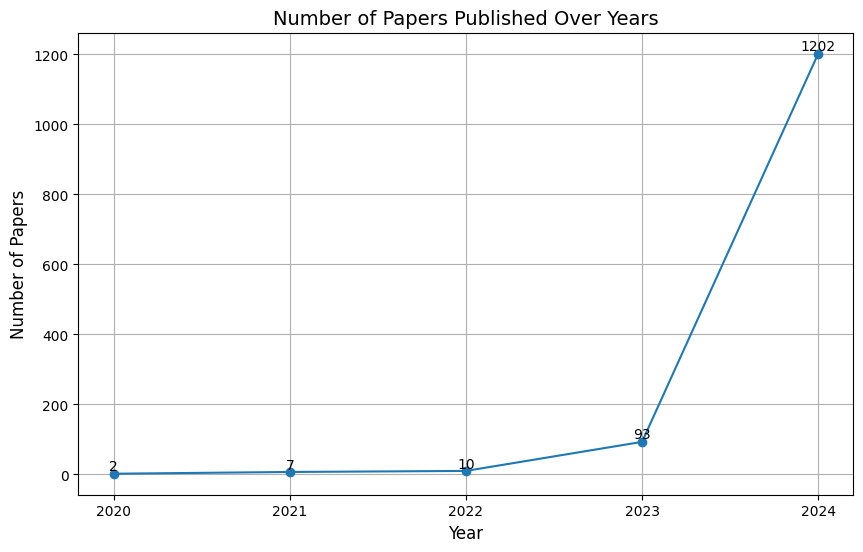

In [17]:
import matplotlib.pyplot as plt
from collections import Counter

# Analyze results: Count papers over years
def analyze_results(csv_file):
    with open(csv_file, "r", encoding="utf-8") as file:
        csvreader = csv.reader(file)
        next(csvreader)  # Skip header
        years = [row[0][:4] for row in csvreader if int(row[0][:4]) > 2014] 

    year_counts = Counter(years)
    return year_counts

# Draw line chart
def draw_chart(year_counts):
    years = sorted(year_counts.keys())
    counts = [year_counts[year] for year in years]

    plt.figure(figsize=(10, 6))
    plt.plot(years, counts, marker="o")
    for year, count in zip(years, counts):
        plt.text(year, count, str(count), fontsize=10, ha="center", va="bottom")
    plt.title("Number of Papers Published Over Years", fontsize=14)
    plt.xlabel("Year", fontsize=12)
    plt.ylabel("Number of Papers", fontsize=12)
    plt.grid(True)
    plt.show()

# Analyze and visualize
csv_file = "data/arxiv_results.csv"
year_counts = analyze_results(csv_file)
draw_chart(year_counts)


# 2.2 Check Papers on Solution Named after RAG

In [22]:


# Specify your CSV file name or path
csv_filename = "data/arxiv_results.csv"
count = 0

# Open and read the CSV file
with open(csv_filename, mode="r", encoding="utf-8") as file:
    reader = csv.DictReader(file)
    
    # Iterate over each row (paper) in the CSV
    for row in reader:
        title = row["Title"]  # Retrieve the paper's title
        
        # Check if "RAG" is in the title (case-sensitive)
        if "RAG" in title:
            print("Link:", row["Link"])
            print("Title:", row["Title"])
            print("-" * 40)  # Separator for clarity

            count += 1

print(f"Total papers with 'RAG' in the title: {count}")


Link: http://arxiv.org/abs/2405.13002v1
Title: DuetRAG: Collaborative Retrieval-Augmented Generation
----------------------------------------
Link: http://arxiv.org/abs/2312.07796v1
Title: Harnessing Retrieval-Augmented Generation (RAG) for Uncovering Knowledge
  Gaps
----------------------------------------
Link: http://arxiv.org/abs/2407.09394v1
Title: PersonaRAG: Enhancing Retrieval-Augmented Generation Systems with
  User-Centric Agents
----------------------------------------
Link: http://arxiv.org/abs/2410.20878v1
Title: AutoRAG: Automated Framework for optimization of Retrieval Augmented
  Generation Pipeline
----------------------------------------
Link: http://arxiv.org/abs/2412.12358v1
Title: BioRAGent: A Retrieval-Augmented Generation System for Showcasing
  Generative Query Expansion and Domain-Specific Search for Scientific Q&A
----------------------------------------
Link: http://arxiv.org/abs/2309.15217v1
Title: RAGAS: Automated Evaluation of Retrieval Augmented Generati

# 2.3 Split Results into Smaller Batches for OpenAI API Calls

In [18]:
# Split CSV into smaller batches
def split_csv(file_name, batch_size):
    with open(file_name, "r", encoding="utf-8") as file:
        csvreader = csv.reader(file)
        header = next(csvreader)  # Save header row
        rows = list(csvreader)

    for i in range(0, len(rows), batch_size):
        batch_rows = rows[i:i+batch_size]
        batch_file_name = f"data/arxiv_results_batch_{i // batch_size + 1}.csv"
        with open(batch_file_name, "w", newline="", encoding="utf-8") as batch_file:
            csvwriter = csv.writer(batch_file)
            csvwriter.writerow(header)
            csvwriter.writerows(batch_rows)
        print(f"Batch saved to {batch_file_name}")

split_csv("data/arxiv_results.csv", 270)

Batch saved to data/arxiv_results_batch_1.csv
Batch saved to data/arxiv_results_batch_2.csv
Batch saved to data/arxiv_results_batch_3.csv
Batch saved to data/arxiv_results_batch_4.csv
Batch saved to data/arxiv_results_batch_5.csv


# 2.2 Track Trends of Categories


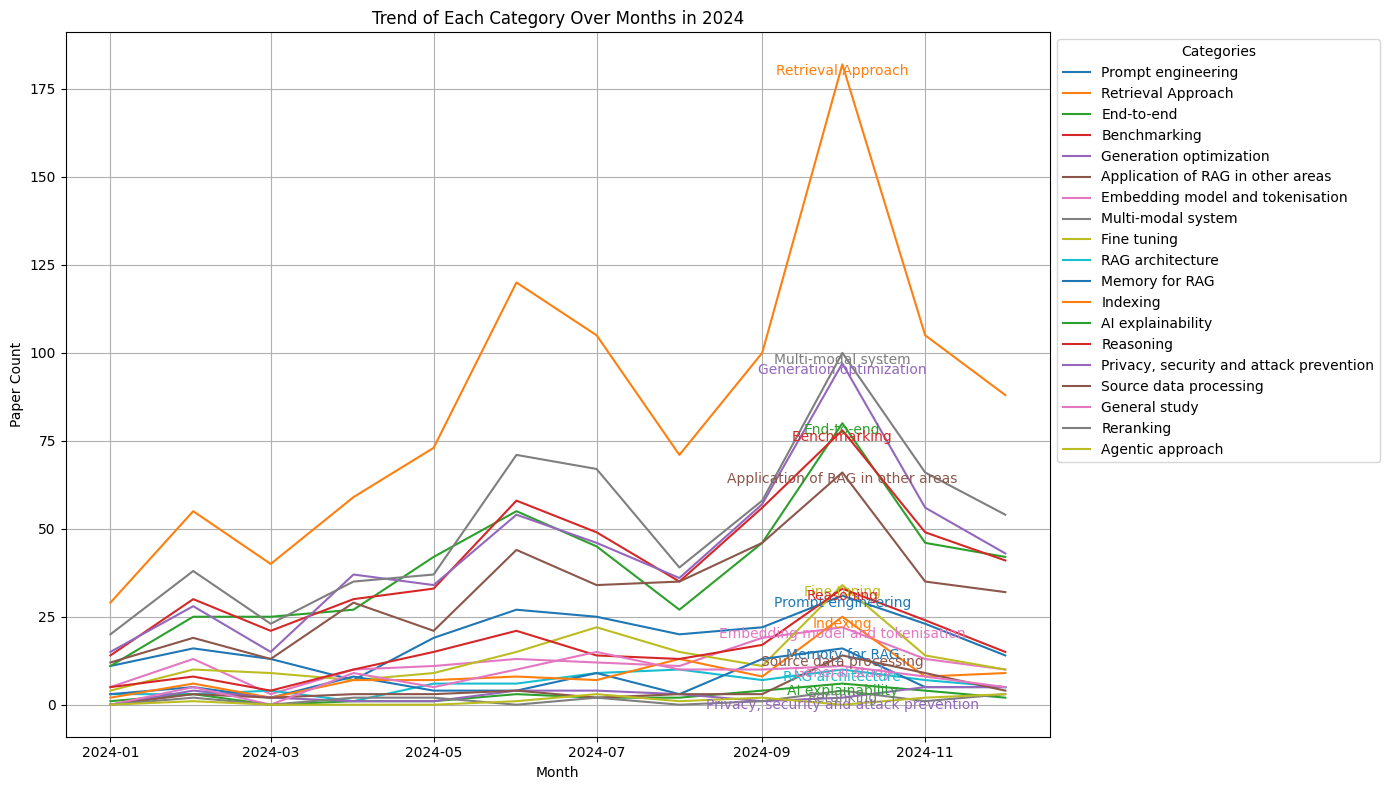

In [50]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

# Define the folder path containing labelled files
labelled_folder_path = "data/labelled"

# Initialize data structures
papers_list = []
labels_by_month = defaultdict(lambda: defaultdict(int))  # {month: {label: count}}

# Step 1: Read each file from the folder
for file_name in os.listdir(labelled_folder_path):
    file_path = os.path.join(labelled_folder_path, file_name)
    if file_name.endswith(".csv"):
        # Load paper data into a list
        df = pd.read_csv(file_path)
        for _, row in df.iterrows():
            papers_list.append(row)

            # Step 2: Process each paper
            link = row["Link"]
            labels = eval(row["Labels"])  # Convert string representation of list to actual list
            year_month = link.split("/")[-1][0:4]  # Extract year and month (e.g., 2407)
            publish_year = int(year_month[:2]) + 2000  # Convert 24 to 2024
            publish_month = int(year_month[2:])
            #publish_date = pd.to_datetime(f"20{year_month[:2]}-{year_month[2:]}", format="%Y-%m", errors='coerce')

            if publish_year is not None and publish_year == 2024:
                # month = publish_date.strftime("%Y-%m")  # Get year-month format

                # Aggregate paper count by label for the month
                for label in labels:
                    labels_by_month[publish_month][label] += 1

# Step 3: Transform data for plotting
labels_df = pd.DataFrame(labels_by_month).fillna(0).T  # Transpose for plotting
labels_df.index = pd.to_datetime(['2024-{0:02d}'.format(month) for month in labels_df.index], format="%Y-%m")
labels_df = labels_df.sort_index()

# Step 4: Plot results
plt.figure(figsize=(14, 8))
for label in labels_df.columns:
    line, = plt.plot(labels_df.index, labels_df[label], label=label)
    # Annotate only the last point for each line
    last_x = labels_df.index[9]
    last_y = labels_df[label].iloc[9]
    if last_y > 0:  # Only annotate lines with data
        plt.text(last_x, last_y, label, fontsize=10, color=line.get_color(), ha='center', va='top')

plt.title("Trend of Each Category Over Months in 2024")
plt.xlabel("Month")
plt.ylabel("Paper Count")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1), title="Categories")
plt.grid(True)
plt.tight_layout()
plt.show()


# 2.4 Group Papers by Categories

Note: as one paper may have multiple labels / belong to multiple categories, the chart below actually shows occurances of paper. 

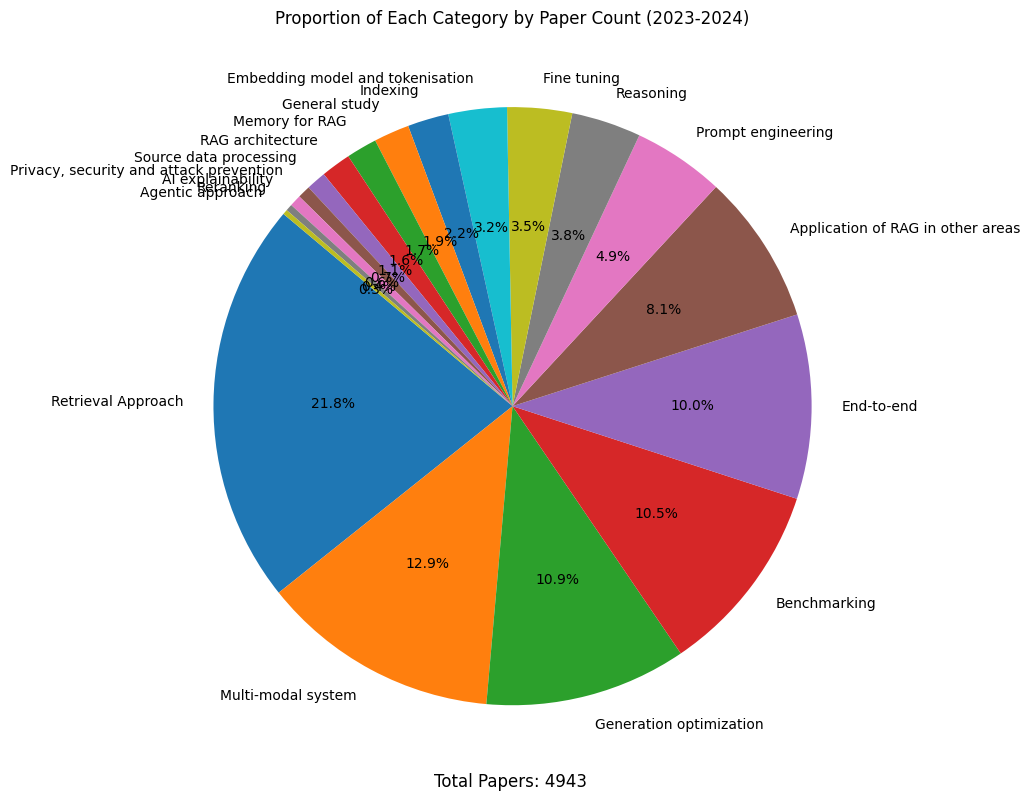

In [52]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

# Define the folder path containing labelled files
labelled_folder_path = "data/labelled"

# Initialize data structures
papers_list = []
labels_count = defaultdict(int)  # {label: count}

# Step 1: Read each file from the folder
for file_name in os.listdir(labelled_folder_path):
    file_path = os.path.join(labelled_folder_path, file_name)
    if file_name.endswith(".csv"):
        # Load paper data into a list
        df = pd.read_csv(file_path)
        for _, row in df.iterrows():
            papers_list.append(row)

            # Step 2: Process each paper
            link = row["Link"]
            labels = eval(row["Labels"])  # Convert string representation of list to actual list
            year_month = link.split("/")[-1][0:4]  # Extract year and month (e.g., 2407)
            publish_year = int(year_month[:2]) + 2000  # Convert 24 to 2024

            if publish_year in [2023, 2024]:
                # Aggregate paper count by label
                for label in labels:
                    labels_count[label] += 1

# Step 3: Transform data for plotting
labels_series = pd.Series(labels_count).sort_values(ascending=False)

# Step 4: Plot results
plt.figure(figsize=(10, 8))
plt.pie(labels_series, labels=labels_series.index, autopct="%1.1f%%", startangle=140, textprops={'fontsize': 10})
plt.title("Proportion of Each Category by Paper Count (2023-2024)")
plt.tight_layout()

# Display total count at the bottom
total_papers = labels_series.sum()
plt.figtext(0.5, 0.01, f"Total Papers: {total_papers}", wrap=True, horizontalalignment='center', fontsize=12)

plt.show()


# 2.5 Show top influential papers of each category

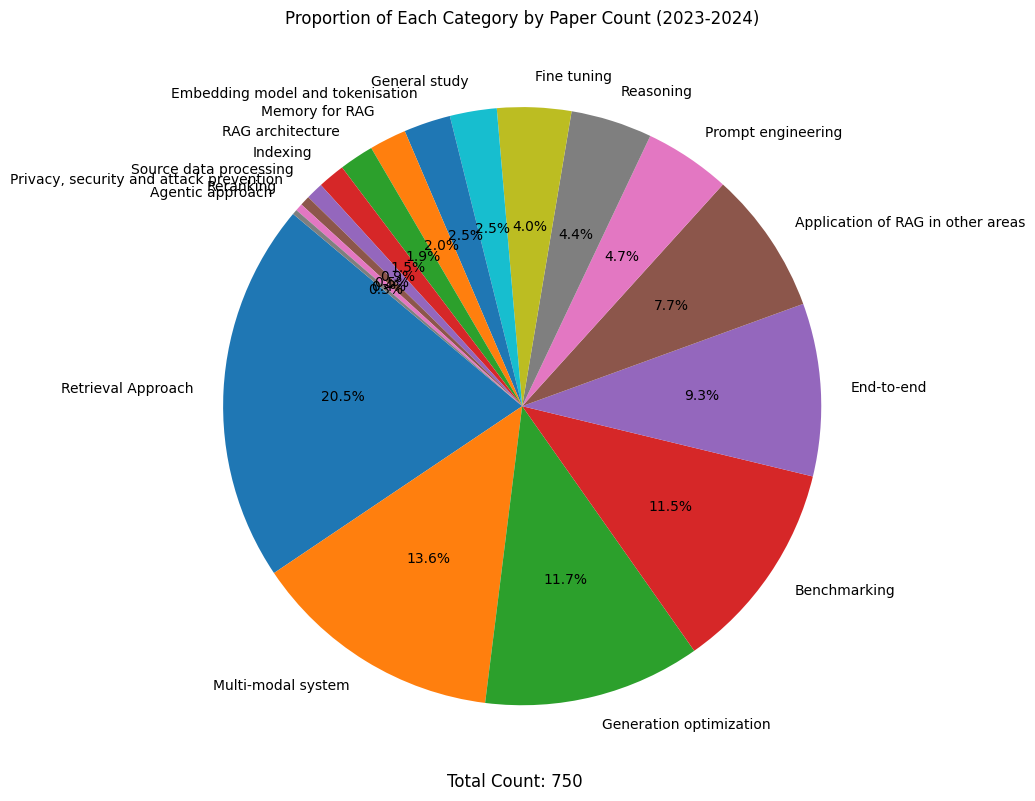


Top 20 Most Cited Papers in Category: Prompt engineering
- Unknown Title (93 citations): http://arxiv.org/abs/2403.10131v2
- Benchmarking Retrieval-Augmented Generation for Medicine (67 citations): http://arxiv.org/abs/2402.13178v2
- The Power of Noise: Redefining Retrieval for RAG Systems (66 citations): http://arxiv.org/abs/2401.14887v4
- RAG vs Fine-tuning: Pipelines, Tradeoffs, and a Case Study on
  Agriculture (42 citations): http://arxiv.org/abs/2401.08406v3
- RAGTruth: A Hallucination Corpus for Developing Trustworthy
  Retrieval-Augmented Language Models (34 citations): http://arxiv.org/abs/2401.00396v2
- G-Retriever: Retrieval-Augmented Generation for Textual Graph
  Understanding and Question Answering (29 citations): http://arxiv.org/abs/2402.07630v3
- RTLFixer: Automatically Fixing RTL Syntax Errors with Large Language
  Models (29 citations): http://arxiv.org/abs/2311.16543v3
- Retrieval-augmented Generation to Improve Math Question-Answering:
  Trade-offs Between Grounde

In [21]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

# Define folder paths and files
labelled_folder_path = "data/labelled"
citations_summary_file = "data/citations_summary.json"
papers_metadata_file = "data/arxiv_results.csv"

# Initialize data structures
papers_list = []
labels_count = defaultdict(int)  # {label: count}
citations_data = {}
metadata = {}
n = 20

# Step 1: Load metadata from papers file
metadata_df = pd.read_csv(papers_metadata_file)
for _, row in metadata_df.iterrows():
    metadata[row["Link"]] = {
        "title": row["Title"],
        "summary": row["Summary"],
        "first_author": row["First Author"]
    }

# Step 2: Load citation data
with open(citations_summary_file, "r") as f:
    citations_summary = json.load(f)
    for entry in citations_summary:
        citations_data[entry["arxiv_id"]] = {
            "link": entry["link"],
            "citations": entry["citations"],
            "influentialPapers": entry["influentialPapers"]
        }

# Step 3: Read each file from the labelled folder
for file_name in os.listdir(labelled_folder_path):
    file_path = os.path.join(labelled_folder_path, file_name)
    if file_name.endswith(".csv"):
        # Load paper data into a list
        df = pd.read_csv(file_path)
        for _, row in df.iterrows():
            link = row["Link"]
            arxiv_id = link.split("/")[-1]
            arxiv_id = arxiv_id.split("v")[0]  # Extract the base ArXiv ID

            # Filter by citation criteria
            if arxiv_id in citations_data:
                citation_entry = citations_data[arxiv_id]
                if citation_entry["citations"] > 0 and len(citation_entry["influentialPapers"]) > 0:
                    # Fetch metadata for the paper
                    metadata_entry = metadata.get(link, {})
                    papers_list.append({
                        "title": metadata_entry.get("title", "Unknown Title"),
                        "link": link,
                        "labels": eval(row["Labels"]),
                        "citations": citation_entry["citations"],
                        "influentialPapers": citation_entry["influentialPapers"]
                    })

                    # Aggregate paper count by label
                    for label in eval(row["Labels"]):
                        labels_count[label] += 1

# Step 4: Transform data for plotting
labels_series = pd.Series(labels_count).sort_values(ascending=False)

# Step 5: Plot results (Pie Chart)
plt.figure(figsize=(10, 8))
plt.pie(labels_series, labels=labels_series.index, autopct="%1.1f%%", startangle=140, textprops={'fontsize': 10})
plt.title("Proportion of Each Category by Paper Count (2023-2024)")
plt.tight_layout()

# Display total count at the bottom
total_papers = labels_series.sum()
plt.figtext(0.5, 0.01, f"Total Count: {total_papers}", wrap=True, horizontalalignment='center', fontsize=12)
plt.show()

# Step 6: Show top 10 most cited papers for each category
top_cited_by_category = defaultdict(list)

for paper in papers_list:
    for label in paper["labels"]:
        top_cited_by_category[label].append(paper)

# Sort each category's papers by citation count and limit to top 20
for label, papers in top_cited_by_category.items():
    top_cited_by_category[label] = sorted(papers, key=lambda x: x["citations"], reverse=True)[:n]

# Display results
for label, papers in top_cited_by_category.items():
    print(f"\nTop {n} Most Cited Papers in Category: {label}")
    for paper in papers:
        print(f"- {paper['title']} ({paper['citations']} citations): {paper['link']}")


# 2.6 Top Papers of Each Category


In [14]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

# Define folder paths and files
labelled_folder_path = "data/labelled"
citations_summary_file = "data/citations_summary.json"
papers_metadata_file = "data/arxiv_results.csv"

#category_filter = "Retrieval Approach"
category_filter = "End-to-end"
#category_filter = "Generation optimization"

output_file = f"data/category/{category_filter}/top30_papers.csv"
output_file = output_file.lower().replace(" ", "-")

# Initialize data structures
papers_list = []
labels_count = defaultdict(int)  # {label: count}
citations_data = {}
metadata = {}

# Step 1: Load metadata from papers file
metadata_df = pd.read_csv(papers_metadata_file)
for _, row in metadata_df.iterrows():
    metadata[row["Link"]] = {
        "title": row["Title"],
        "summary": row["Summary"],
        "first_author": row["First Author"]
    }

# Step 2: Load citation data
with open(citations_summary_file, "r") as f:
    citations_summary = json.load(f)
    for entry in citations_summary:
        citations_data[entry["arxiv_id"]] = {
            "link": entry["link"],
            "citations": entry["citations"],
            "influentialPapers": entry["influentialPapers"]
        }

# Step 3: Read each file from the labelled folder
for file_name in os.listdir(labelled_folder_path):
    file_path = os.path.join(labelled_folder_path, file_name)
    if file_name.endswith(".csv"):
        # Load paper data into a list
        df = pd.read_csv(file_path)
        for _, row in df.iterrows():
            link = row["Link"]
            arxiv_id = link.split("/")[-1]
            arxiv_id = arxiv_id.split("v")[0]  # Extract the base ArXiv ID

            # Filter by citation criteria
            if arxiv_id in citations_data:
                citation_entry = citations_data[arxiv_id]
                if citation_entry["citations"] > 0 and "RAG" in row.get("Solution Name", "Unknown Solution"):
                    # Fetch metadata for the paper
                    metadata_entry = metadata.get(link, {})
                    papers_list.append({
                        "title": metadata_entry.get("title", "Unknown Title"),
                        "link": link,
                        "labels": eval(row["Labels"]),
                        "solution_name": row.get("Solution Name", "Unknown Solution"),
                        "citations": citation_entry["citations"],
                        "summary": row.get("Summary", "")
                    })

                    # Aggregate paper count by label
                    for label in eval(row["Labels"]):
                        labels_count[label] += 1

# Step 4: Focus on category_filter and get top 30 papers
end_to_end_papers = [
    paper for paper in papers_list if category_filter in paper["labels"]
]
end_to_end_papers = sorted(end_to_end_papers, key=lambda x: x["citations"], reverse=True)#[:30]
# Save results for "End-to-End" category to a CSV file
end_to_end_df = pd.DataFrame(end_to_end_papers)
#end_to_end_df.to_csv(output_file, index=False, sep='|')

# Display results for the category
#print(f"Top 30 Most Cited Papers in Category: {category_filter}" )
print(f"Total papers in category: {len(end_to_end_papers)}")
print("Link | Title | Solution Name | Citations | Summary")
for paper in end_to_end_papers:
    print(f"{paper['link']} | {paper['title']} | {paper['solution_name']} | {paper['citations']} | {paper['summary'][:150]}...")
    #print(f"{paper['solution_name']} | {paper['link']} ")

Total papers in category: 70
Link | Title | Solution Name | Citations | Summary
http://arxiv.org/abs/2310.11511v1 | Self-RAG: Learning to Retrieve, Generate, and Critique through
  Self-Reflection | Self-RAG | 348 | we introduce a new framework called
self-reflective retrieval-augmented generation (self-rag) that enhances an lm's
quality and factuality through ret...
http://arxiv.org/abs/2309.15217v1 | RAGAS: Automated Evaluation of Retrieval Augmented Generation | RAGAS | 69 | we introduce ragas (retrieval augmented generation assessment), a framework
for reference-free evaluation of retrieval augmented generation (rag)
pipe...
http://arxiv.org/abs/2403.14403v2 | Adaptive-RAG: Learning to Adapt Retrieval-Augmented Large Language
  Models through Question Complexity | Adaptive-RAG | 60 | retrieval-augmented large language models (llms), which incorporate the
non-parametric knowledge from external knowledge bases into llms, have emerged...
http://arxiv.org/abs/2401.00396v2 | RAGTruth: A

# 2.7 Retrieve and Summarize Scores of Each Model

This part was done using Chatgpt-o1 model with pre-defined template. The results can be found in Top 50 RAG Solutions. 